In [1]:
%pip install darts
%matplotlib widget

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts.metrics import mape, r2_score
from darts import concatenate
import matplotlib.pyplot as plt

In [3]:
## Read data
data = pd.read_parquet(r"..\01_Datenaufbereitung\Output\Calculated\df_01.parquet")
data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'] = pd.to_datetime(data['Absolute_Time[yyyy-mm-dd hh:mm:ss]'])
data = data[['Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'Current[A]', 'Voltage[V]', 'Temperature[°C]', 'SOH_ZHU']]

## Resample to hourly
data.set_index('Absolute_Time[yyyy-mm-dd hh:mm:ss]', inplace=True)
data_hourly = data.resample('h').mean().reset_index()

## Fill missing values
data_hourly.interpolate(method='linear', inplace=True)
data_hourly['SOH_ZHU'] = data_hourly['SOH_ZHU'].fillna(1)
data_hourly

,Absolute_Time[yyyy-mm-dd hh:mm:ss],Current[A],Voltage[V],Temperature[°C],SOH_ZHU
0,2023-02-02 09:00:00,0.178802,3.428232,26.897790,1.00000
1,2023-02-02 10:00:00,-0.513341,3.246093,26.607690,1.00000
2,2023-02-02 11:00:00,-0.046780,3.280055,26.384056,1.00000
3,2023-02-02 12:00:00,-0.033134,3.281391,26.386694,1.00000
4,2023-02-02 13:00:00,-0.036126,3.279641,26.387583,1.00000
...,...,...,...,...,...
5418,2023-09-16 03:00:00,-0.154366,3.303888,26.789917,0.92246
5419,2023-09-16 04:00:00,-0.158398,3.274568,26.786639,0.92246
5420,2023-09-16 05:00:00,-0.269575,3.254702,26.771611,0.92246
5421,2023-09-16 06:00:00,-0.090656,3.269142,26.762205,0.92246


Text(0.5, 0, 'Time')

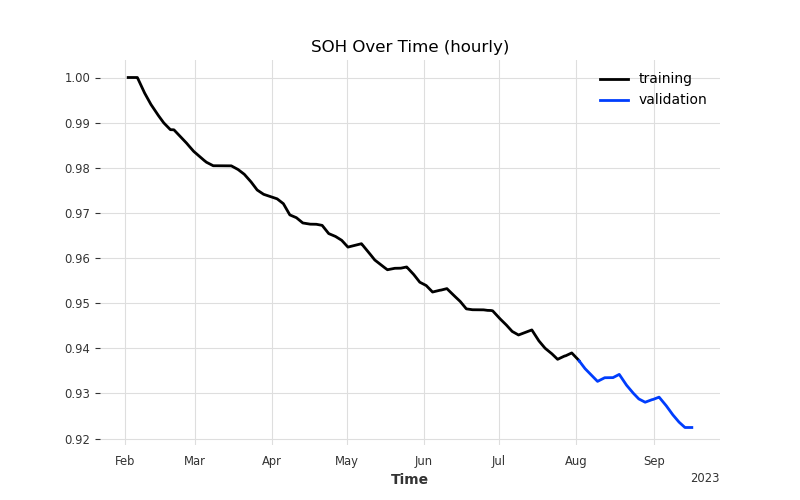

In [4]:
## Data to time series
target_series = TimeSeries.from_dataframe(data_hourly, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', 'SOH_ZHU')
covariates = TimeSeries.from_dataframe(data_hourly, 'Absolute_Time[yyyy-mm-dd hh:mm:ss]', ['Current[A]', 'Voltage[V]', 'Temperature[°C]'])

## Time align
target_series, covariates = target_series.slice_intersect(covariates), covariates.slice_intersect(target_series)

## Covariates normalization
scaler = Scaler()
## Don't scale SOH
covariates_scaled = scaler.fit_transform(covariates)

## Data split

train, val = target_series.split_after(0.8)
cov_train, cov_val = covariates_scaled.split_after(0.8)
plt.figure(figsize=(8, 5))
train.plot(label="training")
val.plot(label="validation")
plt.title("SOH Over Time (hourly)")
plt.xlabel("Time")

In [6]:
## Model definition
model_name = "NBeats"
model = NBEATSModel(
    input_chunk_length=24,
    output_chunk_length=12,
    random_state=42,
    save_checkpoints=True
)

In [ ]:
model.fit(series=train, past_covariates=cov_train, 
          val_series=val, val_past_covariates=cov_val, epochs=50, verbose=True)


c:\Users\zzhuqshun\.conda\envs\ML\lib\site-packages\darts\models\forecasting\torch_forecasting_model.py:1842: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model: TorchForec

Predicting: |          | 0/? [00:00<?, ?it/s]

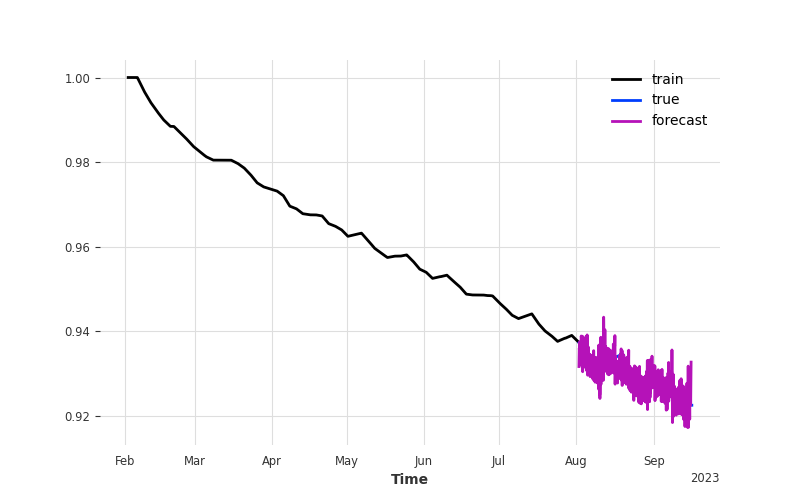

In [5]:
model_nbeats = NBEATSModel.load_from_checkpoint('2024-10-28_23_07_19_torch_model_run_28204')
pred_series = model_nbeats.historical_forecasts(start = train.end_time() - pd.Timedelta(hours=1),  
                                   series = target_series,
                                   past_covariates = covariates_scaled,
                                   forecast_horizon=12,
                                   stride=12,
                                   last_points_only=False, 
                                   retrain=False,
                                   verbose=True
                                   )

pred_series = concatenate(pred_series) 

plt.figure(figsize=(8, 5)) 
train.plot(label="train")
val.plot(label="true")
pred_series.plot(label="forecast")
plt.legend()
plt.xlabel('Time')
plt.show()

In [ ]:
# class BatteryPredictor:
#     def __init__(self, input_chunk_length=30, output_chunk_length=5,
#                  num_stacks=10, num_blocks=1, num_layers=4, layer_widths=512,
#                  batch_size=32, n_epochs=100):
#         """
#         Initialize the Battery Predictor with N-BEATS model
        
#         Args:
#             input_chunk_length (int): Length of input sequences
#             output_chunk_length (int): Length of prediction horizon
#             num_stacks (int): Number of stacks in N-BEATS architecture
#             num_blocks (int): Number of blocks per stack
#             num_layers (int): Number of layers per block
#             layer_widths (int): Width of layers in the network
#             batch_size (int): Training batch size
#             n_epochs (int): Number of training epochs
#         """
#         self.input_chunk_length = input_chunk_length
#         self.output_chunk_length = output_chunk_length
#         self.scaler = MinMaxScaler()
        
#         # Initialize N-BEATS model with specified parameters
#         self.model = NBEATSModel(
#             input_chunk_length=input_chunk_length,
#             output_chunk_length=output_chunk_length,
#             num_stacks=num_stacks,
#             num_blocks=num_blocks,
#             num_layers=num_layers,
#             layer_widths=layer_widths,
#             likelihood=GaussianLikelihood(),
#             batch_size=batch_size,
#             n_epochs=n_epochs,
#             random_state=42
#         )

#     def prepare_data(self, data, target_col, time_col=None):
#         """
#         Prepare time series data for the model
        
#         Args:
#             data (pd.DataFrame): Input DataFrame containing the time series data
#             target_col (str): Name of the target column (SOC or SOH)
#             time_col (str, optional): Name of the timestamp column
            
#         Returns:
#             TimeSeries: Darts TimeSeries object ready for modeling
#         """
#         # Ensure data is sorted by time
#         if time_col is not None:
#             data = data.sort_values(time_col)
        
#         # Scale the target data
#         scaled_data = self.scaler.fit_transform(data[[target_col]])
        
#         # Create Darts TimeSeries object
#         if time_col:
#             series = TimeSeries.from_dataframe(
#                 pd.DataFrame(scaled_data, index=data[time_col], columns=[target_col])
#             )
#         else:
#             series = TimeSeries.from_values(scaled_data)
            
#         return series

#     def train_test_split(self, series, train_ratio=0.8):
#         """
#         Split time series into training and testing sets
        
#         Args:
#             series (TimeSeries): Input time series data
#             train_ratio (float): Ratio of data to use for training
            
#         Returns:
#             tuple: (training series, testing series)
#         """
#         train_len = int(len(series) * train_ratio)
#         train_series = series[:train_len]
#         test_series = series[train_len:]
#         return train_series, test_series

#     def train(self, train_series, val_series=None):
#         """
#         Train the N-BEATS model
        
#         Args:
#             train_series (TimeSeries): Training data
#             val_series (TimeSeries, optional): Validation data
#         """
#         self.model.fit(
#             train_series,
#             val_series=val_series,
#             verbose=True
#         )

#     def predict(self, n_steps, series=None):
#         """
#         Make predictions using the trained model
        
#         Args:
#             n_steps (int): Number of steps to predict
#             series (TimeSeries, optional): Series to start prediction from
            
#         Returns:
#             numpy.ndarray: Predicted values in original scale
#         """
#         prediction = self.model.predict(n=n_steps, series=series)
#         # Inverse transform the predictions back to original scale
#         prediction_values = prediction.values()
#         original_scale_pred = self.scaler.inverse_transform(prediction_values)
#         return original_scale_pred

#     def evaluate(self, actual_series, pred_series):
#         """
#         Evaluate model performance using multiple metrics
        
#         Args:
#             actual_series (TimeSeries): Actual values
#             pred_series (TimeSeries): Predicted values
            
#         Returns:
#             dict: Dictionary containing various performance metrics
#         """
#         results = {
#             'MAPE': mape(actual_series, pred_series),
#             'RMSE': rmse(actual_series, pred_series),
#             'MAE': mae(actual_series, pred_series)
#         }
#         return results

#     def plot_predictions(self, actual_series, pred_series, title="Battery Prediction"):
#         """
#         Plot actual vs predicted values
        
#         Args:
#             actual_series (TimeSeries): Actual values
#             pred_series (TimeSeries): Predicted values
#             title (str): Plot title
#         """
#         plt.figure(figsize=(12, 6))
#         plt.plot(actual_series.values(), label='Actual', color='blue')
#         plt.plot(pred_series.values(), label='Predicted', color='red')
#         plt.title(title)
#         plt.legend()
#         plt.grid(True)
#         plt.show()

# # Example usage
# def main():
#     """
#     Example of how to use the BatteryPredictor class
    
#     Expected data format:
#     data = pd.DataFrame({
#         'timestamp': [...],  # Datetime column
#         'SOC': [...],       # State of Charge values
#         'temperature': [...],# Temperature values
#         'current': [...],   # Current values
#         'voltage': [...]    # Voltage values
#     })
#     """
    
#     # Initialize the predictor
#     predictor = BatteryPredictor(
#         input_chunk_length=30,    # Use 30 timesteps for prediction
#         output_chunk_length=5,    # Predict next 5 timesteps
#         num_stacks=10,           # Number of stacks in N-BEATS
#         num_blocks=1,            # Blocks per stack
#         layer_widths=512,        # Width of neural network layers
#         batch_size=32,           # Training batch size
#         n_epochs=100            # Number of training epochs
#     )
    
#     # Prepare your data
#     # series = predictor.prepare_data(
#     #     data=data,
#     #     target_col='SOC',    # or 'SOH'
#     #     time_col='timestamp'
#     # )
    
#     # # Split into training and testing sets
#     # train_series, test_series = predictor.train_test_split(series)
    
#     # # Train the model
#     # predictor.train(train_series, val_series=test_series)
    
#     # # Make predictions
#     # predictions = predictor.predict(n_steps=len(test_series))
    
#     # # Evaluate performance
#     # metrics = predictor.evaluate(test_series, predictions)
#     # print("Model Performance:", metrics)
    
#     # # Visualize results
#     # predictor.plot_predictions(test_series, predictions, "SOC Prediction")

# if __name__ == "__main__":
#     main()